In [1]:
from IPython.display import Markdown
x=10
Markdown(f"**variable**: {x}")

**variable**: 10

In [34]:
# titanic数据集的目标是根据乘客信息预测他们在Titanic号撞击冰山沉没后能否生存。

# 结构化数据一般会使用Pandas中的DataFrame进行预处理。

In [35]:
## 数据准备

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import models,layers

dftrain_raw = pd.read_csv('../data/titanic/train.csv')
dftest_raw = pd.read_csv('../data/titanic/test.csv')
dftrain_raw.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
5,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
6,228,0,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.2500,NaN,S
7,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
8,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,NaN,S
9,752,1,3,"Moor, Master. Meier",male,6.0,0,1,392096,12.4750,E121,S


In [4]:
# 字段说明：

# * Survived:0代表死亡，1代表存活【y标签】
# * Pclass:乘客所持票类，有三种值(1,2,3) 【转换成onehot编码】
# * Name:乘客姓名 【舍去】
# * Sex:乘客性别 【转换成bool特征】
# * Age:乘客年龄(有缺失) 【数值特征，添加“年龄是否缺失”作为辅助特征】
# * SibSp:乘客兄弟姐妹/配偶的个数(整数值) 【数值特征】
# * Parch:乘客父母/孩子的个数(整数值)【数值特征】
# * Ticket:票号(字符串)【舍去】
# * Fare:乘客所持票的价格(浮点数，0-500不等) 【数值特征】
# * Cabin:乘客所在船舱(有缺失) 【添加“所在船舱是否缺失”作为辅助特征】
# * Embarked:乘客登船港口:S、C、Q(有缺失)【转换成onehot编码，四维度 S,C,Q,nan】

In [ ]:
# 利用Pandas的数据可视化功能我们可以简单地进行探索性数据分析EDA（Exploratory Data Analysis）。

# label分布情况

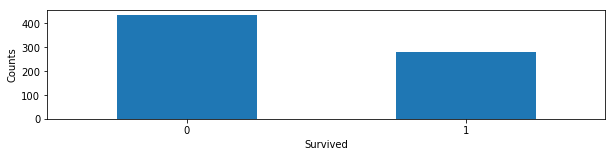

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw['Survived'].value_counts().plot(kind = 'bar',
     figsize = (10,2),fontsize=10,rot = 0)
ax.set_ylabel('Counts',fontsize = 10)
ax.set_xlabel('Survived',fontsize = 10)
plt.show()

In [36]:
## 年龄分布情况

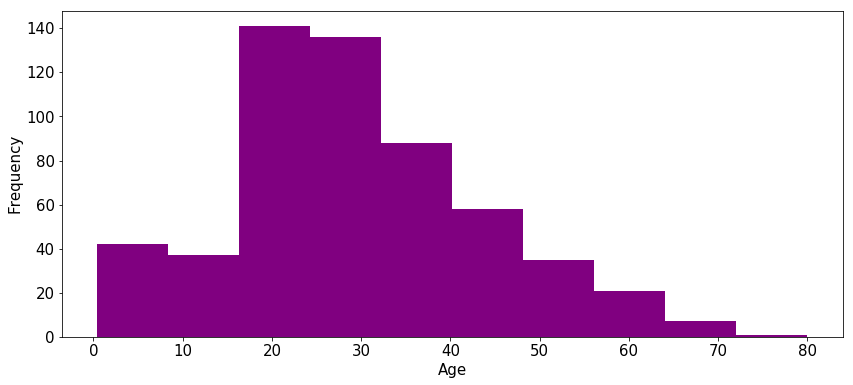

In [40]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw['Age'].plot(kind = 'hist',bins = 10,color= 'purple',
                    figsize = (14,6),fontsize=15)

ax.set_ylabel('Frequency',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

In [41]:
## 年龄和label的相关性

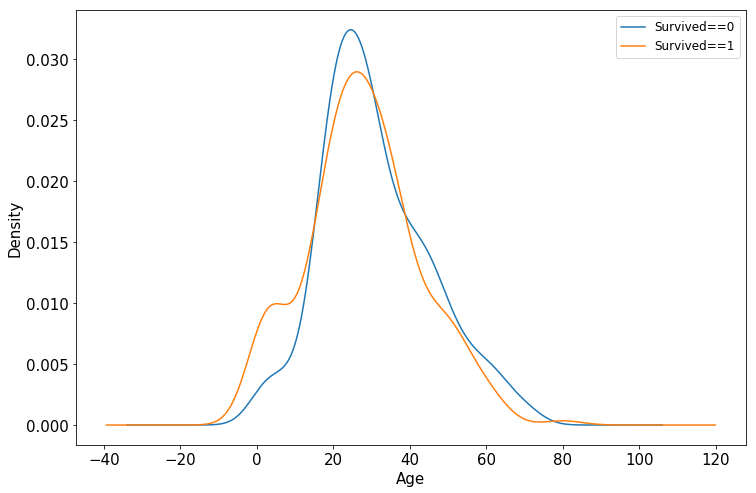

In [42]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw.query('Survived == 0')['Age'].plot(kind = 'density',
                      figsize = (12,8),fontsize=15)
dftrain_raw.query('Survived == 1')['Age'].plot(kind = 'density',
                      figsize = (12,8),fontsize=15)
ax.legend(['Survived==0','Survived==1'],fontsize = 12)
ax.set_ylabel('Density',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

In [43]:
## 数据预处理 

In [12]:
def preprocessing(dfdata):

    dfresult= pd.DataFrame()

    #Pclass
    dfPclass = pd.get_dummies(dfdata['Pclass'])
    dfPclass.columns = ['Pclass_' +str(x) for x in dfPclass.columns ]
    dfresult = pd.concat([dfresult,dfPclass],axis = 1)

    #Sex
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult,dfSex],axis = 1)

    #Age
    dfresult['Age'] = dfdata['Age'].fillna(0)
    dfresult['Age_null'] = pd.isna(dfdata['Age']).astype('int32')

    #SibSp,Parch,Fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']

    #Carbin
    dfresult['Cabin_null'] =  pd.isna(dfdata['Cabin']).astype('int32')

    #Embarked
    dfEmbarked = pd.get_dummies(dfdata['Embarked'],dummy_na=True)
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult,dfEmbarked],axis = 1)

    return(dfresult)

In [13]:
x_train = preprocessing(dftrain_raw)
y_train = dftrain_raw['Survived'].values

x_test = preprocessing(dftest_raw)
y_test = dftest_raw['Survived'].values

print("x_train.shape =", x_train.shape )
print("x_test.shape =", x_test.shape )

x_train.shape = (712, 15)
x_test.shape = (179, 15)


### 定义模型

In [14]:
# 使用Keras接口有以下3种方式构建模型：
#1）使用Sequential按层顺序构建模型，
#2）使用函数式API构建任意结构模型，
#3）继承Model基类构建自定义模型。

# 此处选择使用最简单的Sequential，按层顺序模型。

In [44]:
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(20,activation = 'relu',input_shape=(15,)))
model.add(layers.Dense(10,activation = 'relu' ))
model.add(layers.Dense(1,activation = 'sigmoid' ))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


In [45]:
# 训练模型通常有3种方法，内置fit方法，内置train_on_batch方法，以及自定义训练循环。
# 此处我们选择最常用也最简单的内置fit方法。

In [46]:
# 二分类问题选择二元交叉熵损失函数
model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['AUC'])

history = model.fit(x_train,y_train,
                    batch_size= 64,
                    epochs= 30,
                    validation_split=0.2 #分割一部分训练数据用于验证
                   )

W0426 15:43:58.748164 140736610247616 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


Train on 569 samples, validate on 143 samples
Epoch 1/30
569/569 [==============================] - 0s 579us/sample - loss: 1.9788 - AUC: 0.3891 - val_loss: 1.7642 - val_AUC: 0.4009
Epoch 2/30
569/569 [==============================] - 0s 57us/sample - loss: 1.5526 - AUC: 0.4463 - val_loss: 1.4525 - val_AUC: 0.4407
Epoch 3/30
569/569 [==============================] - 0s 60us/sample - loss: 1.1997 - AUC: 0.5129 - val_loss: 1.1809 - val_AUC: 0.5463
Epoch 4/30
569/569 [==============================] - 0s 58us/sample - loss: 0.8936 - AUC: 0.6095 - val_loss: 0.8857 - val_AUC: 0.5952
Epoch 5/30
569/569 [==============================] - 0s 60us/sample - loss: 0.8251 - AUC: 0.6525 - val_loss: 0.8191 - val_AUC: 0.6367
Epoch 6/30
569/569 [==============================] - 0s 63us/sample - loss: 0.7611 - AUC: 0.6577 - val_loss: 0.7801 - val_AUC: 0.6029
Epoch 7/30
569/569 [==============================] - 0s 60us/sample - loss: 0.7128 - AUC: 0.6444 - val_loss: 0.7228 - val_AUC: 0.6185
Epoch 8/

In [47]:
## 评估模型 
## 评估模型在训练集和验证集上的效果 

In [48]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

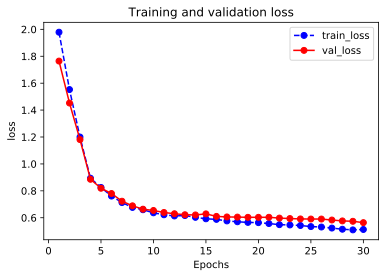

In [49]:
plot_metric(history,"loss")

In [50]:
model.evaluate(x = x_test,y = y_test)

W0426 15:45:41.170040 140736610247616 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


179/179 [==============================] - 0s 58us/sample - loss: 0.5351 - AUC: 0.7861


[0.5350916229146819, 0.7860564]

In [52]:
x_test.shape, x_train.shape 

((179, 15), (712, 15))

In [53]:
x_test[0:6]

,Pclass_1,Pclass_2,Pclass_3,female,male,Age,Age_null,SibSp,Parch,Fare,Cabin_null,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,0,0,1,1,0,0.00,1,8,2,69.5500,1,0,0,1,0
1,0,0,1,1,0,20.00,0,0,0,8.6625,1,0,0,1,0
2,0,0,1,1,0,9.00,0,3,2,27.9000,1,0,0,1,0
3,1,0,0,1,0,18.00,0,1,0,227.5250,0,1,0,0,0
4,0,0,1,1,0,0.75,0,2,1,19.2583,1,1,0,0,0
5,0,1,0,1,0,28.00,0,0,0,12.6500,1,0,0,1,0


In [54]:
## 模型使用 

In [22]:
#预测概率
model.predict(x_test[0:10])
#model(tf.constant(x_test[0:10].values,dtype = tf.float32)) #等价写法

W0426 15:20:58.080106 140736610247616 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


array([[0.10380328],
       [0.4839411 ],
       [0.26582798],
       [0.72343767],
       [0.35957867],
       [0.67230433],
       [0.1183596 ],
       [0.6620768 ],
       [0.30809164],
       [0.10845947]], dtype=float32)

In [55]:
#预测类别
model.predict_classes(x_test[0:10])

W0426 15:48:07.805253 140736610247616 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


array([[0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0]], dtype=int32)

## save model 

In [56]:
# 可以使用Keras方式保存模型，也可以使用TensorFlow原生方式保存。
# 前者仅仅适合使用Python环境恢复模型，后者则可以跨平台进行模型部署。
# 推荐使用后一种方式进行保存。

In [63]:
## 1) keras 方式模型保存

In [59]:
# 保存模型结构及权重
model.save('../data/keras_model.h5')  

del model  #删除现有模型

# identical to the previous one
model = models.load_model('../data/keras_model.h5')
model.evaluate(x_test,y_test)

In [26]:
# 保存模型结构
json_str = model.to_json()
# 恢复模型结构
model_json = models.model_from_json(json_str)

In [29]:
#保存模型权重
model.save_weights('../data/keras_model_weight.h5')

# 恢复模型结构
model_json = models.model_from_json(json_str)
model_json.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['AUC']
    )

# 加载权重
model_json.load_weights('../data/keras_model_weight.h5')
model_json.evaluate(x_test,y_test)

W0426 15:29:12.668905 140736610247616 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


179/179 [==============================] - 0s 425us/sample - loss: 0.4914 - AUC: 0.8231


[0.49143822499493645, 0.8231391]

In [62]:
## 2) tensorflow 原生方式保存  

In [32]:
# 保存权重，该方式仅仅保存权重张量
model.save_weights('../data/tf_model_weights.ckpt',save_format = "tf")

In [33]:
# 保存模型结构与模型参数到文件,该方式保存的模型具有跨平台性便于部署
model.save('../data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

model_loaded = tf.keras.models.load_model('../data/tf_model_savedmodel')
model_loaded.evaluate(x_test,y_test)

W0426 15:33:35.417685 140736610247616 deprecation.py:506] From /anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1781: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


export saved model.


W0426 15:33:36.377240 140736610247616 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


179/179 [==============================] - 0s 423us/sample - loss: 0.4914 - AUC: 0.8231


[0.49143822499493645, 0.8231391]